# 2. Grouping customers together!

In [1]:
# importing required packages
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime as dt
import matplotlib.pyplot as plt

## 2.1 Getting your data + feature engineering

In [2]:
# reading data
data = pd.read_csv('bank_transactions.csv', delimiter = ',')
# renaming TransactionAmount (INR) column
data.rename(columns = {"TransactionAmount (INR)":"TransactionAmount_INR"}, inplace = True)

In [3]:
data.columns

Index(['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender',
       'CustLocation', 'CustAccountBalance', 'TransactionDate',
       'TransactionTime', 'TransactionAmount_INR'],
      dtype='object')

#### Formatting DateTime

In [4]:
# cleaning data
# dropping na, reformatting date times

data.dropna(inplace=True)#? doesnt change
data.CustomerDOB = pd.to_datetime(data.CustomerDOB) 
data.TransactionDate = pd.to_datetime(data.TransactionDate) 
data.TransactionTime = data.TransactionTime.apply(lambda x: dt.strptime(str(x).zfill(6), '%H%M%S').time() )

#### Offset the people born after 2000 and drop the Customer born before 1900

In [5]:
data_cop = data.copy()
data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)
data.drop(data[data.CustomerDOB.dt.year < 1900].index, axis=0, inplace=True)

We reformat the data to remove some unnatural occurences of dates of births (DOB). The CustomerIDs with a DOB in 1800 are dropped. DOBs over 2000 are set off by 100 years. The modified data seems more natural.

Text(0.5, 1.0, 'CustomerDOB modified')

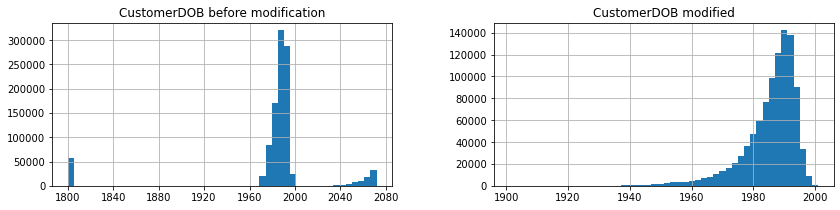

In [6]:
fig, ax = plt.subplots(1,2, figsize = (14, 3))

hist = data_cop.hist(column='CustomerDOB', bins = 50, ax = ax[0])
ax[0].set_title('CustomerDOB before modification')
hist2 = data.hist(column='CustomerDOB', bins = 50, ax = ax[1])
ax[1].set_title('CustomerDOB modified')

### Number of transaction per CustomerID

In [7]:
# nr_trans 
nr_trans = data[['CustomerID','TransactionID']].groupby(by = 'CustomerID').count()
nr_trans.rename(columns = {'TransactionID' : 'nr_trans'}, inplace = True)

### Number of transaction that have a value larger than 100

In [8]:
# nr of transactions that exceed 100 INR
nr_trans_greater_100 = data[['CustomerID','TransactionAmount_INR']].query("TransactionAmount_INR > 100").groupby(by= "CustomerID").count()
nr_trans.rename(columns = {'TransactionAmount_INR' : 'trans_greater_100'}, inplace = True)

### Mean of transactions for each customer

In [9]:
#  mean_trans 
mean_trans = data[['CustomerID','TransactionAmount_INR']].groupby(by='CustomerID').mean()
mean_trans.rename(columns = {'TransactionAmount_INR':'mean_trans' }, inplace = True)

### Mean of total Balance for each customerID

In [10]:
# mean_balance
mean_balance = data[['CustomerID','CustAccountBalance']].groupby(by='CustomerID').mean()
mean_balance.rename(columns = {'CustAccountBalance':'mean_balance' }, inplace = True)

### Mean difference between the mean balance and the mean transaction

In [11]:
#mean_diff. Aka Utilization
mean_diff = pd.DataFrame( mean_balance.mean_balance.sub(mean_trans.mean_trans, axis = 0) )
mean_diff.columns = ['mean_diff']

### Most frequent gender for each customerID

In [12]:
gender_most_freq = data.groupby(by = 'CustomerID').apply(lambda x: x['CustGender'].value_counts().index[0])
gender_most_freq = pd.DataFrame(gender_most_freq)
gender_most_freq.columns = ['gender_most_freq']
# converting 'M' to 1 and 'F' to 0
gender_most_freq['gender_most_freq'] = gender_most_freq['gender_most_freq'].apply(lambda x: 1 if x=='M' else 0)

### Most frequent location 

In [13]:
# most_freq_loc new
most_freq_loc = data.groupby(by='CustomerID').apply(lambda x: x['CustLocation'].value_counts().index[0])
most_freq_loc = pd.DataFrame(most_freq_loc)
most_freq_loc.columns = [ 'most_freq_loc']

### Merge all the 7 features into one df

In [14]:
# merging nr_trans and nr_trans_greater_100 separately to ensure correct format
nr_trans_and_nr_greater_100 = nr_trans.merge(nr_trans_greater_100, on= 'CustomerID', how='left').fillna(0)
# all the dfs to be concatenated
dfs = [nr_trans_and_nr_greater_100, mean_trans, mean_balance, mean_diff, gender_most_freq, most_freq_loc]

df_7 = pd.concat(dfs, 1)

/var/folders/c0/1q90pl8n3k50gnjpfmzf_lzh0000gn/T/ipykernel_31625/3440457736.py:6: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df_7 = pd.concat(dfs, 1)


In [15]:
# saving for later usage
df_7.to_csv('seven_params_3.csv', sep=',', encoding='utf-8', index = False)

## 20 features

In [22]:
def findMinMaxTrans(data) -> pd.DataFrame:
    return data.groupby("CustomerID").agg(  min_trans = ("TransactionAmount_INR", min),
                                            max_trans = ("TransactionAmount_INR", max),
                                            )

In [36]:
def findQuant(data, quant) -> pd.DataFrame:
    df = data.groupby('CustomerID')[['CustomerID','TransactionAmount_INR']].quantile(quant)
    return df.rename(columns = {'TransactionAmount_INR':f'{quant}_quant_trans' })

In [47]:
def findTransValueVar(data) -> pd.DataFrame:
    var =  data.groupby('CustomerID').apply(lambda group: group['TransactionAmount_INR'].nunique()/len(group['TransactionAmount_INR']))
    return pd.DataFrame(var).rename(columns={'TransactionAmount_INR':'trans_val_var'})

In [53]:
def findMinMaxDiffBalance(data) -> pd.DataFrame:
    df =  data.groupby("CustomerID").agg(  min_balance = ("CustAccountBalance", min),
                                            max_balance = ("CustAccountBalance", max),
                                            )
    df['diff_balance'] =  df.max_balance.sub(df.min_balance, axis = 0)
    return df

In [80]:

def findTransactionTimes(data) -> pd.DataFrame:
    hours_data = data[['CustomerID', 'TransactionTime']]
    hours_data['TransactionTime'] = pd.to_datetime((hours_data['TransactionTime']).astype(str)).dt.hour
    mean_hour = hours_data.groupby(by = 'CustomerID').mean()
    max_hour = hours_data.groupby(by = 'CustomerID').max()
    min_hour = hours_data.groupby(by = 'CustomerID').min()
    most_freq_hour = hours_data.groupby(by = 'CustomerID')['TransactionTime'].apply(lambda x: x.value_counts().index[0])
    most_freq_hour = pd.DataFrame(most_freq_hour)

    df = pd.concat([mean_hour, max_hour, min_hour, most_freq_hour], 1)
    df.columns = ['mean_hour', 'max_hour', 'min_hour', 'most_freq_hour']

    return df

In [165]:
def findTransactionDate(data) -> pd.DataFrame:
    dates = data[['CustomerID', 'TransactionDate']]
    #dates['dt'] = pd.to_datetime(dates.TransactionDate.astype(str))
    most_freq_weekday = dates.groupby(by = 'CustomerID').apply(lambda group: group.TransactionDate.dt.weekday.value_counts().index[0])
    most_freq_month = dates.groupby(by = 'CustomerID').apply(lambda group: group.TransactionDate.dt.month.value_counts().index[0])
    nr_diff_months = dates.groupby(by = 'CustomerID').apply(lambda group: group.TransactionDate.dt.month.nunique())

    frame = {'most_freq_weekday': most_freq_weekday, 'most_freq_month': most_freq_month, 'nr_diff_months': nr_diff_months}
    df = pd.DataFrame(frame)
    return df

In [112]:
def findNrLocs(data) -> pd.DataFrame:
    df =  pd.DataFrame(data.groupby(by = 'CustomerID')['CustLocation'].nunique())
    df.columns = ['nr_diff_locs']
    return df

In [113]:
def findNrDOB(data) -> pd.DataFrame:
    df = pd.DataFrame(data.groupby(by = 'CustomerID')['CustomerDOB'].nunique())
    df.columns = ['nr_diff_dob']
    return df

In [206]:
def findMeanAge(data):
    df = data[['CustomerID', 'TransactionDate', 'CustomerDOB']].groupby(by = 'CustomerID').apply(lambda group: (group.TransactionDate-group.CustomerDOB ).astype('timedelta64[Y]').mean() )# might have to select in data already
    df = pd.DataFrame(df)
    df.columns = ['mean_age_trans']
    return df

In [171]:
def findNrTrans1K(data) -> pd.DataFrame:
    df = data[['CustomerID','TransactionAmount_INR']].query("TransactionAmount_INR > 100").groupby(by= "CustomerID").count()
    df.columns = ['trans_greater_1k']
    return df

In [141]:
def findNrBalance100K(data) -> pd.DataFrame:
    df = data[['CustomerID','CustAccountBalance']].query("CustAccountBalance > 100").groupby(by= "CustomerID").count()
    df.columns = ['balance_greater_100k']
    return df

In [198]:
def findTrans_ValBalRatio(data) -> pd.DataFrame:
    mean_ratio = data.groupby(by = 'CustomerID').apply(lambda group: (group.TransactionAmount_INR / group.CustAccountBalance).mean())
    max_ratio = data.groupby(by = 'CustomerID').apply(lambda group: (group.TransactionAmount_INR / group.CustAccountBalance).min())
    frame = {'mean_ratio': mean_ratio, 'max_ratio': max_ratio}
    df = pd.DataFrame(frame)
    return df

In [207]:
def features_20(data): 
    
    #min and max of transaction for each customerID
    min_max_trans = findMinMaxTrans(data)
    #quantiles of transactions for each customerID
    quant_75_trans = findQuant(data, 0.75)
    quant_25_trans = findQuant(data, 0.25)
    # ratio of unique transactions amounts for customerID
    trans_val_var = findTransValueVar(data)
    
    #min and max of balance for each customerID
    min_max_diff_balance = findMinMaxDiffBalance(data)
    
    # get max_hour, min_hour, mean_hour and most frequent hour of transactions for customerID
    transaction_times = findTransactionTimes(data)
    
    # get most frequent weekdy, most frequent month, and number of differnt months for transactions done by the customerID
    transaction_dates = findTransactionDate(data)
    
    # number of different locations from which a customerID has made transactions
    nr_diff_locs = findNrLocs(data)
    
    # nr of unique dates of birth for customerID, might roughly be the number of people using the account
    nr_diff_dob = findNrDOB(data) 
    
    # mean age of customerID at times of transaction (in years)
    age_mean = findMeanAge(data)
    
    # number transactions that exceed 1000 INR
    nr_trans_1k = findNrTrans1K(data) # dimension!
    
    # number transaction instances at which the customer balance was > 100000
    nr_balance_100k = findNrBalance100K(data)
    
    # transaction amount/balance ratio , return the mean and max of this ratio
    trans_valbalratio = findTrans_ValBalRatio(data)

    # merging dataframes with different dimensionality separately
    pre_df = min_max_trans.merge(nr_trans_1k, on = 'CustomerID', how = 'left').fillna(0)
    pre_df = pre_df.merge(nr_balance_100k, on = 'CustomerID', how = 'left').fillna(0)

    df_all = pd.concat([pre_df, quant_75_trans, quant_25_trans, trans_val_var, min_max_diff_balance, transaction_times, transaction_dates, 
                        nr_diff_locs, nr_diff_dob, age_mean, trans_valbalratio], 1)
    
    return df_all    

    # these were originally included:
    #avg_nr_trans_perday = group.groupby(by= 'TransactionDate').count().mean()
    #first_freq_loc = group['CustLocation'].agg(lambda x:x.value_counts().index[0])
    #std_balance = group['CustAccountBalance'].std()
    

In [173]:
# calling the function features_20() for the data 'bank_transactions.csv'
data_20 = features_20(data)

/var/folders/c0/1q90pl8n3k50gnjpfmzf_lzh0000gn/T/ipykernel_3943/457625945.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  df = data.groupby('CustomerID')[['CustomerID','TransactionAmount_INR']].quantile(quant)
/var/folders/c0/1q90pl8n3k50gnjpfmzf_lzh0000gn/T/ipykernel_3943/457625945.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  df = data.groupby('CustomerID')[['CustomerID','TransactionAmount_INR']].quantile(quant)
/var/folders/c0/1q90pl8n3k50gnjpfmzf_lzh0000gn/T/ipykernel_3943/1643579581.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [26]:
data_20.head()

,CustomerID,min_trans,max_trans,trans_greater_1k,balance_greater_100k,0.75_quant_trans,0.25_quant_trans,trans_val_var,min_balance,max_balance,...,min_hour,most_freq_hour,most_freq_weekday,most_freq_month,nr_diff_months,nr_diff_locs,nr_diff_dob,mean_age_trans,mean_ratio,max_ratio
0,C1010011,356.0,4750.0,2.0,2.0,3651.50,1454.50,1.0,32500.73,120180.54,...,1,12,0,9,1,2,2,28.0,0.074556,0.002962
1,C1010012,1499.0,1499.0,1.0,1.0,1499.00,1499.00,1.0,24204.49,24204.49,...,20,20,6,8,1,1,1,22.0,0.061931,0.061931
2,C1010014,250.0,1205.0,2.0,2.0,966.25,488.75,1.0,38377.14,161848.76,...,15,15,4,1,2,1,2,27.0,0.016472,0.001545
3,C1010018,30.0,30.0,0.0,1.0,30.00,30.00,1.0,496.18,496.18,...,17,17,3,9,1,1,1,26.0,0.060462,0.060462
4,C1010024,5000.0,5000.0,1.0,1.0,5000.00,5000.00,1.0,87058.65,87058.65,...,14,14,3,8,1,1,1,51.0,0.057433,0.057433


In [203]:
# storing for later usage
data_20.to_csv('twenty_params_2.csv', sep = ',', encoding = 'utf-8')

# 2.2 Choose your features (variables)!